https://www.kaggle.com/competitions/playground-series-s4e11

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

<h1>Data Preprocessing/Analyzing</h1>

In [109]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [110]:
# Get unique values in categorical columns. This is needed because there is some bad data that cannot be automated out
cols = ["Gender", "Working Professional or Student", "Dietary Habits", 
        "Have you ever had suicidal thoughts ?", "Family History of Mental Illness"]

print("TRAIN:")
for i in cols:
    print(f"---{i}---")
    print(train[i].unique())

print("\nTEST:")
for i in cols:
    print(f"---{i}---")
    print(test[i].unique())

TRAIN:
---Gender---
['Female' 'Male']
---Working Professional or Student---
['Working Professional' 'Student']
---Dietary Habits---
['Healthy' 'Unhealthy' 'Moderate' 'Yes' 'Pratham' 'BSc' 'Gender' '3'
 'More Healthy' 'Less than Healthy' 'Mihir' '1.0' 'Hormonal' 'Electrician'
 nan 'No Healthy' 'Less Healthy' 'M.Tech' 'Vegas' 'No' 'Male' 'Indoor'
 'Class 12' '2']
---Have you ever had suicidal thoughts ?---
['No' 'Yes']
---Family History of Mental Illness---
['No' 'Yes']

TEST:
---Gender---
['Male' 'Female']
---Working Professional or Student---
['Working Professional' 'Student']
---Dietary Habits---
['Moderate' 'Healthy' 'Unhealthy' 'More Healthy' 'No' 'Indoor' 'Prachi'
 nan 'Male' 'Less Healthy' 'Mealy' 'Resistant' 'MCA' '5 Healthy'
 'Academic' 'Educational' 'Soham' '5 Unhealthy' 'Vivaan' 'Raghav' '1.0'
 'Naina' 'Kolkata']
---Have you ever had suicidal thoughts ?---
['No' 'Yes']
---Family History of Mental Illness---
['Yes' 'No']


In [111]:
# Clean out bad values
train.loc[~train["Dietary Habits"].isin(["Healthy", "Unhealthy", "Moderate"]), "Dietary Habits"] = "Moderate"
test.loc[~test["Dietary Habits"].isin(["Healthy", "Unhealthy", "Moderate"]), "Dietary Habits"] = "Moderate"

In [112]:
# Check that cleaning worked
cols = ["Gender", "Working Professional or Student", "Dietary Habits", 
        "Have you ever had suicidal thoughts ?", "Family History of Mental Illness"]

print("TRAIN:")
for i in cols:
    print(f"---{i}---")
    print(train[i].unique())

print("\nTEST:")
for i in cols:
    print(f"---{i}---")
    print(test[i].unique())

TRAIN:
---Gender---
['Female' 'Male']
---Working Professional or Student---
['Working Professional' 'Student']
---Dietary Habits---
['Healthy' 'Unhealthy' 'Moderate']
---Have you ever had suicidal thoughts ?---
['No' 'Yes']
---Family History of Mental Illness---
['No' 'Yes']

TEST:
---Gender---
['Male' 'Female']
---Working Professional or Student---
['Working Professional' 'Student']
---Dietary Habits---
['Moderate' 'Healthy' 'Unhealthy']
---Have you ever had suicidal thoughts ?---
['No' 'Yes']
---Family History of Mental Illness---
['Yes' 'No']


In [113]:
XTrain = train.drop(["Profession", "Sleep Duration", "Degree", "CGPA", "City", "id", "Name", "Depression"], axis = 1)
yTrain = train["Depression"]

XTest = test.drop(["Profession", "Sleep Duration", "Degree", "CGPA", "City", "id", "Name"], axis = 1)

# encoding categorical columns
catCols = XTrain.select_dtypes(include = ["object"]).columns
# Filter out incorrectly input data
catCols = [col for col in catCols if XTrain[col].nunique() > 1]
XTrain = pd.get_dummies(XTrain, columns = catCols)
XTest = pd.get_dummies(XTest, columns = catCols)

# cleaning up NaNs
imputer = SimpleImputer(strategy = "mean")
XTrain = pd.DataFrame(imputer.fit_transform(XTrain), columns = XTrain.columns)
XTest = pd.DataFrame(imputer.fit_transform(XTest), columns = XTest.columns)

XTrain.to_csv("XTrain.csv", index = False)
XTest.to_csv("XTest.csv", index = False)

print(XTrain.shape)
print(XTest.shape)

# Make into numpy arrays
XTrain = XTrain.values
yTrain = yTrain.values
XTest = XTest.values

# Make into tensors
XTrain = torch.FloatTensor(XTrain)
yTrain = torch.LongTensor(yTrain)
XTest = torch.FloatTensor(XTest)

(140700, 18)
(93800, 18)


<h1>Building the model</h1>

In [114]:
class Model(nn.Module):
    def __init__(self, inFeats = 18, h1 = 10, h2 = 15, outFeats = 2):
        super().__init__()
        self.fc1 = nn.Linear(inFeats, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, outFeats)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [115]:
# Seeding model for reproducible results
torch.manual_seed(251)

In [116]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .01)

<h1>Training the model</h1>

In [117]:
# Train
# Determine # of epochs
epochs = 100
losses = []
for i in range(epochs):
    # Go forward and get a pred
    yPred = model.forward(XTrain)

    # measure loss
    loss = criterion(yPred, yTrain) # predicted val vs actual val

    # Keep track of losses
    losses.append(loss.detach().numpy()) # stored for later graphing purposes

    # Print every 10 epochs
    if i % 10 == 0:
        print(f"Epoch: {i}, Loss: {loss}")

    # Back propogation
    # Error rate of forward propogation fed back through the network to finetune weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0, Loss: 1.0752705335617065
Epoch: 10, Loss: 0.35518091917037964
Epoch: 20, Loss: 0.25027480721473694
Epoch: 30, Loss: 0.21523962914943695
Epoch: 40, Loss: 0.1943252980709076
Epoch: 50, Loss: 0.17705762386322021
Epoch: 60, Loss: 0.16687560081481934
Epoch: 70, Loss: 0.16222672164440155
Epoch: 80, Loss: 0.15951016545295715
Epoch: 90, Loss: 0.1582859307527542


Text(0.5, 0, 'epoch')

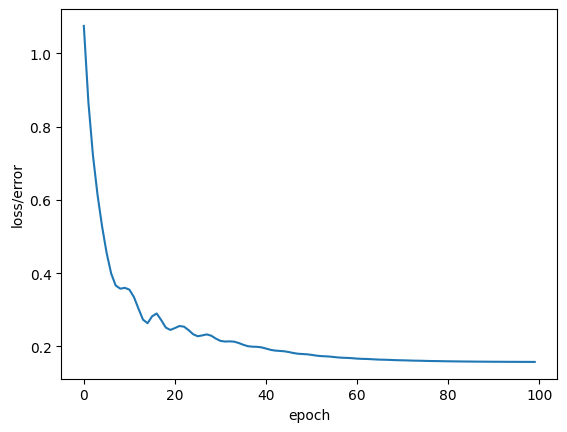

In [118]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel("epoch")

# Does have a 'leveling out'- model is learning!

In [119]:
# Lets see how many we're getting correct in training data out of 140701

correct = 0
with torch.no_grad():
    for i, data in enumerate(XTrain):
        yVal = model.forward(data)

        #print(f"{i + 1}.) {str(yVal)} \t {yTrain[i]}")

        #correct or not
        if yVal.argmax().item() == yTrain[i]:
            correct += 1

print(f"{correct} were correct") # ~93%!

131783 were correct


<h1>Generate Results</h1>

In [120]:
results = []

with torch.no_grad():
    model.eval()
    for i, data in enumerate(XTest):
        yVal = model(data)
        pred = yVal.argmax().item()

        #print(f"{i + 1}.) Prediction: {pred}")

        results.append(f"{pred}")

df = pd.DataFrame({
    "id": test["id"],
    "Depression": results
})

df.to_csv("preds.csv", index=False)
print(len(df))

93800
